In [19]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [20]:
def order_data_bytime(data):  #Here we encapsulate everything that happens at the same time together (It is easier to animate this way) 
    '''Change to use your variables of interest'''
    DS = data.to_dataframe()
    lon = np.array(DS.sort_values(by='time').lon)
    lat = np.array(DS.sort_values(by='time').lat)
    z = np.array(DS.sort_values(by='time').z)
    age = np.array(DS.sort_values(by='time').tau)/3600
    wa = np.array(DS.sort_values(by='time').wa)
    ws = np.array(DS.sort_values(by='time').ws)
    T = np.array(DS.sort_values(by='time').time)

    Tint = []
    for ti in T:
        try:
            Tint.append(int(ti)) 
        except TypeError: 
            pass
            
    Tint = np.array(Tint)
    Age = []
    Z = []
    Lat = []
    Lon = []
    Wa = []
    Ws = []
    t = time[0]
    while int(t) < int(time[-1]): 
        Lat.append(lat[np.where(Tint==int(t))])
        Lon.append(lon[np.where(Tint==int(t))])
        Age.append(age[np.where(Tint==int(t))])
        Wa.append(wa[np.where(Tint==int(t))])
        Ws.append(ws[np.where(Tint==int(t))])
        Z.append(z[np.where(Tint==int(t))])
        t+=np.timedelta64(odt, 'h')

    return Lat,Lon,Age,Z,Wa,Ws

In [21]:
# surf=xr.open_dataset(paths['mask'],decode_times=False).coast_mask[0,1,:,:]
# fig,ax=plt.subplots(1,1,figsize=(5,10))
# ax.contour(surf)
# ax.set_aspect(1/np.sin(np.deg2rad(49)))

In [22]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/testrestart.yaml'

In [23]:
param = load_config1(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
odt = param['param']['odt'] #max depth difference from dmin
name = param['file']['name'] #name output file

#WS = param['particle']['Ws']

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(paths['out'], fn)
outfile2 = outfile[:-5]+'restart.zarr'

In [24]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [25]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_zarr(outfile)
ds2 = xr.open_zarr(outfile2)
ds = xr.concat([ds,ds2], dim='obs')

In [66]:
DS=ds.to_dataframe()

DSsed=DS[DS.beached==3.0]
DSbe=DS[DS.beached==1.0]
DScol=DS[DS.beached==0.0]
DSlost=DS[DS.beached==4.0]

Sedlon=np.array(DSsed.iloc[:,14])#.sort_values(by='time')
Seddepth=np.array(DSsed.iloc[:,-1])#.sort_values(by='time')
Sedlat=np.array(DSsed.iloc[:,12])#.sort_values(by='time')

Belon=np.array(DSbe.iloc[:,14])#.sort_values(by='time')
Belat=np.array(DSbe.iloc[:,12])#.sort_values(by='time')

Collon=np.array(DScol.iloc[:,14])#.sort_values(by='time')
Collat=np.array(DScol.iloc[:,12])#.sort_values(by='time')

lostlon=np.array(DSlost.iloc[:,14])#.sort_values(by='time')
lostdepth=np.array(DSlost.iloc[:,-1])#.sort_values(by='time')
lostlat=np.array(DSlost.iloc[:,12])#.sort_values(by='time')

In [67]:
def distancia(lat2,lon2):
    R = 6371e3
    la1 = float(outf_lat) * math.pi/180
    la2 = lat2 * math.pi/180
    deltlat = (lat2-float(outf_lat)) * math.pi/180
    deltlon = (lon2-float(outf_lon)) * math.pi/180
    a = np.sin(deltlat/2) * np.sin(deltlat/2) + np.cos(la1) * np.cos(la2) * np.sin(deltlon/2) * np.sin(deltlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c 
dcol = distancia(Collat,Collon)
dsink = distancia(Sedlat,Sedlon)
dbeach = distancia(Belat,Belon)

In [68]:
#countime = [] 
#for t in time:
#    countime.append(len(DScol.time[DScol.time==t]))
#np.savetxt("time_2.csv", countime, delimiter=",")
countime=np.genfromtxt('time0.csv', delimiter=',')
countime1=np.genfromtxt('time1.csv', delimiter=',')
countime2=np.genfromtxt('time_2.csv', delimiter=',')

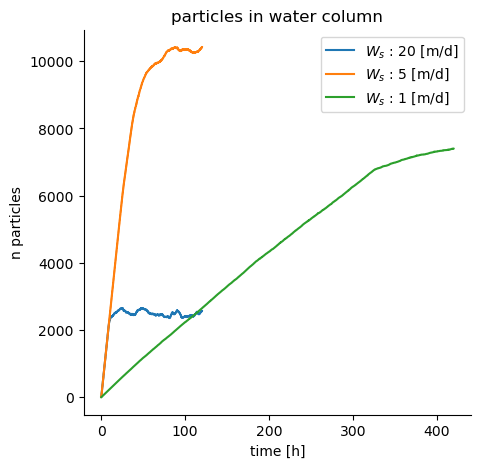

In [69]:
Time=np.linspace(0,120,28810)
Time2=np.linspace(0,420,10082)
fig,ax=plt.subplots(1,figsize=(5,5))
plt.plot(Time,countime,label='$W_s$ : 20 [m/d]')
plt.plot(Time,countime1,label='$W_s$ : 5 [m/d]')
plt.plot(Time2,countime2,label='$W_s$ : 1 [m/d]')
plt.legend()
plt.xlabel('time [h]')
plt.ylabel('n particles')
plt.title('particles in water column')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Text(0.5, 1.0, 'Particles beached')

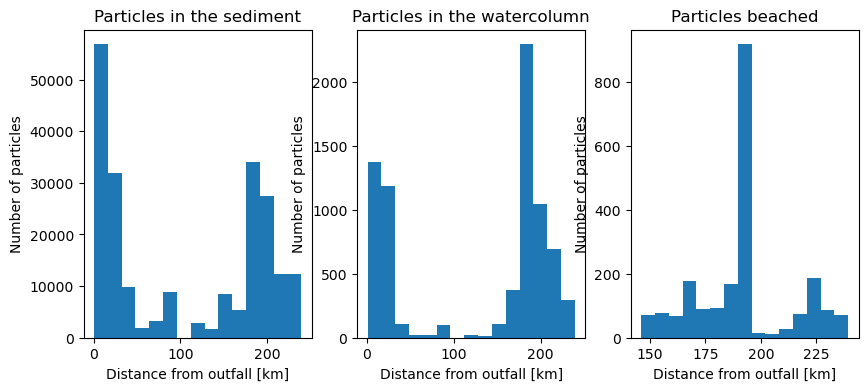

In [70]:
fig,axs=plt.subplots(1,3,figsize=(10,4))
axs[0].hist(dsink/1e3, bins = 15)
axs[0].set_xlabel('Distance from outfall [km]')
axs[0].set_ylabel('Number of particles')
axs[0].set_title('Particles in the sediment')

axs[1].hist(dcol/1e3, bins = 15)
axs[1].set_xlabel('Distance from outfall [km]')
axs[1].set_ylabel('Number of particles')
axs[1].set_title('Particles in the watercolumn')

axs[2].hist(dbeach/1e3, bins = 15)
axs[2].set_xlabel('Distance from outfall [km]')
axs[2].set_ylabel('Number of particles')
axs[2].set_title('Particles beached')

Text(0.05, 0.5, 'Latitude')

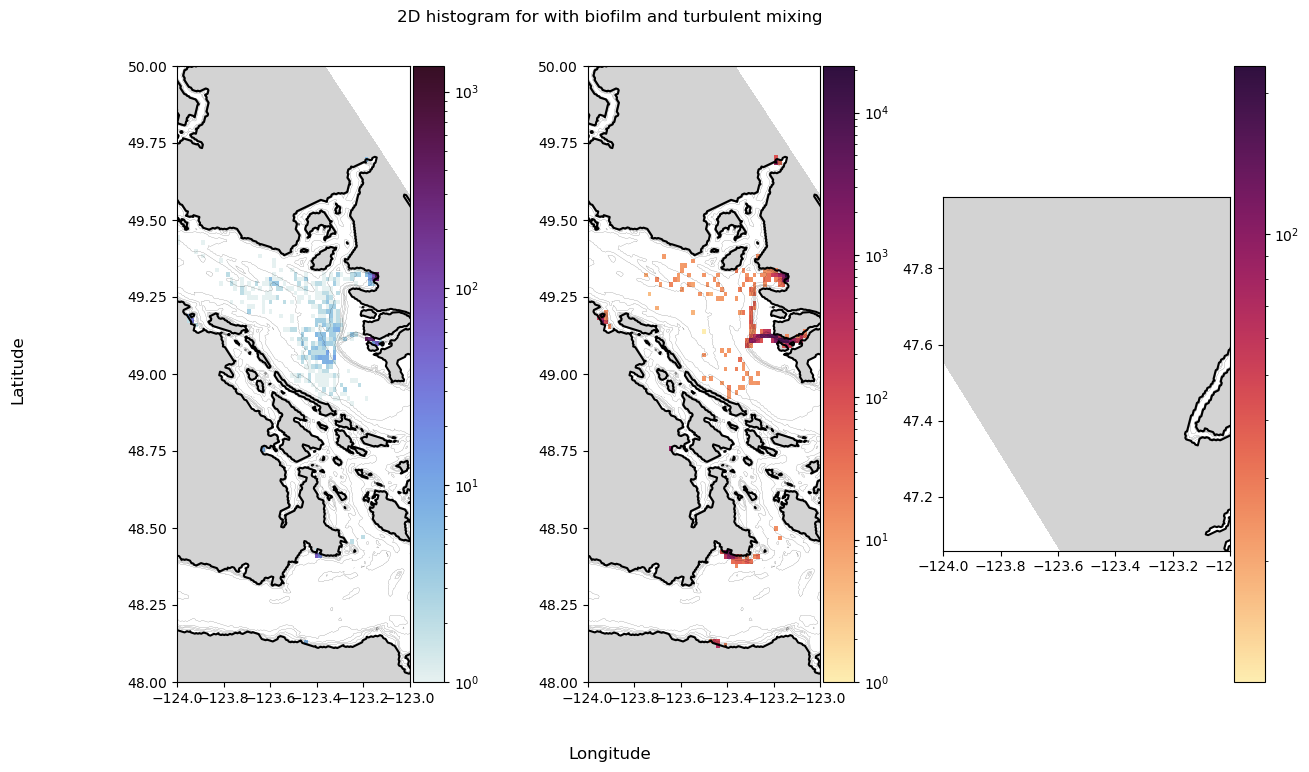

In [71]:
cm = cmocean.cm.dense

fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15, 8))
ax1.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax1.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax1.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax2.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax2.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax2.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax3.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax3.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax3.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')


aa=ax1.hist2d(Collon,Collat,200,norm = colors.LogNorm(), cmap =cm)
cb2=fig.colorbar(aa[3],ax=ax1,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15
ax1.set_xlim([-124,-123])
ax1.set_ylim([48,50])


aa2=ax2.hist2d(Sedlon,Sedlat,200,norm = colors.LogNorm(), cmap =cmocean.cm.matter)
ax2.set_xlim([-124,-123])
ax2.set_ylim([48,50])
cb2=fig.colorbar(aa2[3],ax=ax2,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15

aa=ax3.hist2d(Belon,Belat,100,norm = colors.LogNorm(), cmap =cmocean.cm.matter)
cb2=fig.colorbar(aa[3],ax=ax3,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15
ax3.set_xlim([-124,-123])

#ax1.set_xticks(np.arange(-125, -122, step=1))
#ax2.set_xticks(np.arange(-125, -122, step=1))
#ax3.set_xticks(np.arange(-125, -122, step=1))
ax1.set_aspect(1/np.sin(np.deg2rad(49)))
ax2.set_aspect(1/np.sin(np.deg2rad(49)))
ax3.set_aspect(1/np.sin(np.deg2rad(49)))


fig.suptitle(f'2D histogram for with biofilm and turbulent mixing',y=0.95,x=0.45)
fig.supxlabel('Longitude',x=0.45)
fig.supylabel('Latitude',x=0.05)
#plt.savefig("/home/jvalenti/MOAD/2dhist.pdf")

In [32]:
DS=ds.to_dataframe()
dss=DS[DS.beached==0]## In the water column
dssla=np.array(dss.lat)
dsslo=np.array(dss.lon)
dsscon= np.array(dss.tau)
dssdep=np.array(dss.z)

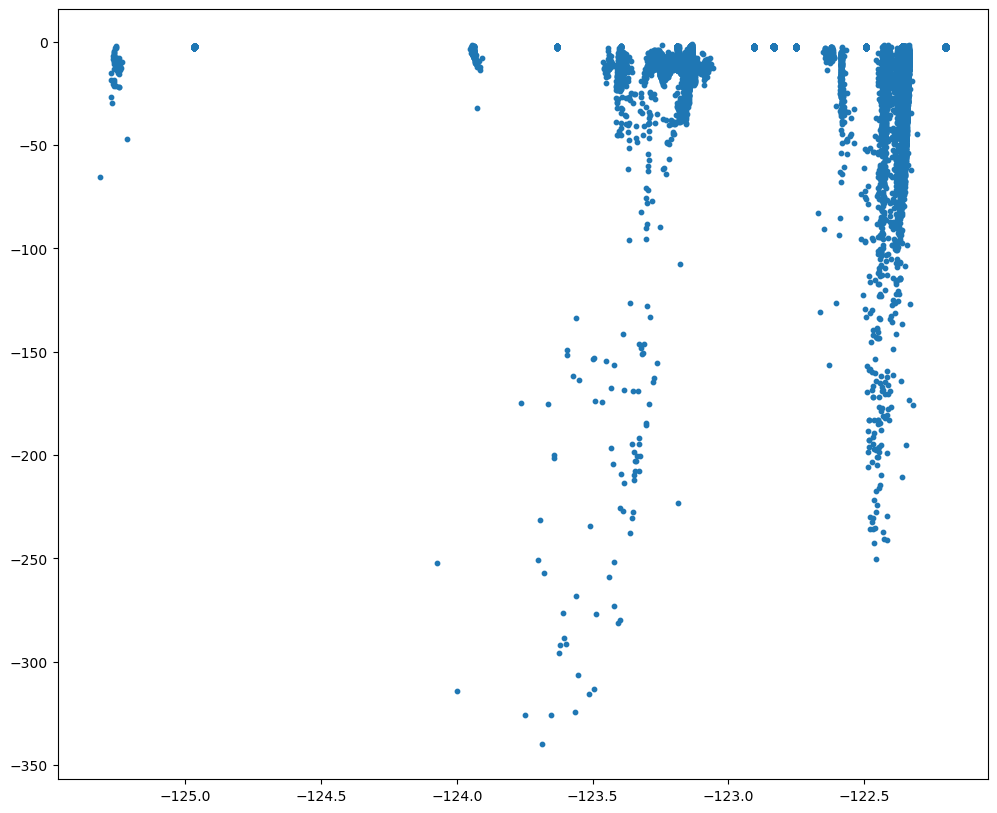

In [72]:
# #Green Particles are on the sediment
time = ds.time[0]
fig, axs = plt.subplots(1,figsize=(12, 10))
Lat,Lon,Age,Z,Wa,Ws = order_data_bytime(ds)
axs.scatter(Lon[12] ,-Z[12],s=10,zorder=2)


In [34]:
def scatter_particles(ax,nmin,lat,lon,Z,vmin,vmax,Map=1): 
    scatter=[]
    if Map == 0:     
        scatter.append(ax.scatter(lon[nmin], lat[nmin],s=4,c=Z[nmin],cmap=cmocean.cm.tempo,vmin=vmin,vmax=vmax,alpha=0.5))  
    else:
        scatter.append(ax.scatter(lon[nmin], lat[nmin],s=4,c=Z[nmin],cmap=cmocean.cm.tempo,vmin=vmin,vmax=vmax,alpha=0.5,
                                  zorder=3,transform=crs.PlateCarree()))
    return scatter

def mapanimation(ds,clon,clat,vmin,vmax,fps=1,Map=1):
    
    time = ds.time[0,:]
    Lat,Lon,Age,Z,Wa,Ws = order_data_bytime(ds)
    
    fig = plt.figure(figsize=(8, 8))
    lonmin = np.min(ds.lon)
    lonmax = np.max(ds.lon)
    latmin = np.min(ds.lat)
    latmax = np.max(ds.lat)
    ax = plt.axes(xlim=(lonmin,lonmax),ylim=(latmin,latmax))
    plt.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
    #plt.scatter(clon,clat,color='r',zorder=5)
    ax.grid()
    f = 1.0/np.cos(49.5*np.pi/180)
    plt.gca().set_aspect(f)

    def update(frame):
        global ss
        for scat in ss:
            scat.remove()
        t = ax.text(0.02, 0.02, '', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'), transform=ax.transAxes)
        tstamp = time[frame].values.astype('datetime64[s]').astype(datetime)
        t.set_text(tstamp.strftime('%Y-%b-%d %H:%M'))
        ss = scatter_particles(ax, frame, Lat,Lon,Z,vmin,vmax,Map)
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(time[:-1]),fps))

/home/jvalenti/conda_envs/general/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/jvalenti/conda_envs/general/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/jvalenti/conda_envs/general/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/jvalenti/conda_envs/general/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/jvalenti/conda_envs/general/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/jvalenti/conda_envs/general/l

ValueError: list.remove(x): x not in list

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f947c27f9a0> (for post_execute):


ValueError: list.remove(x): x not in list

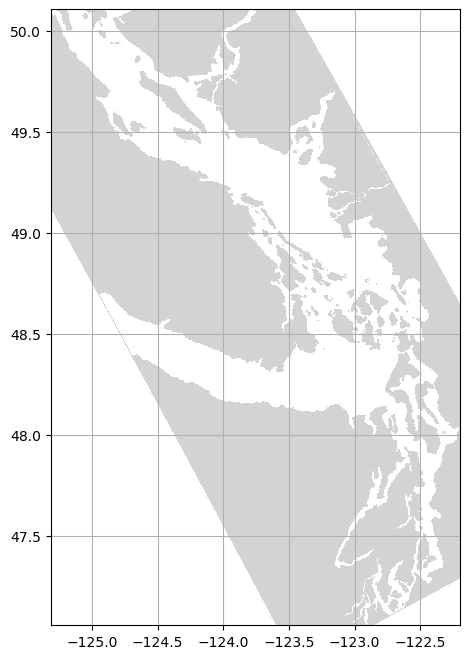

In [39]:
anim = mapanimation(ds,clon,clat,0,20,1,Map=0)

f2 = r"/home/jvalenti/anim.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f2, writer = FFwriter)

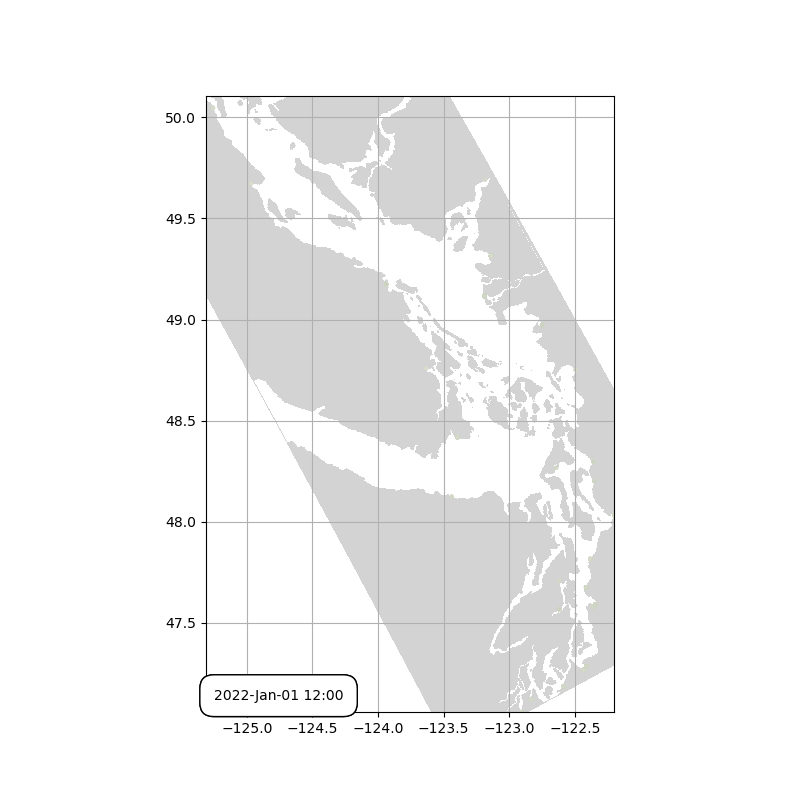

In [ ]:
with open(f2,'rb') as anim:
  display(Image(anim.read()))

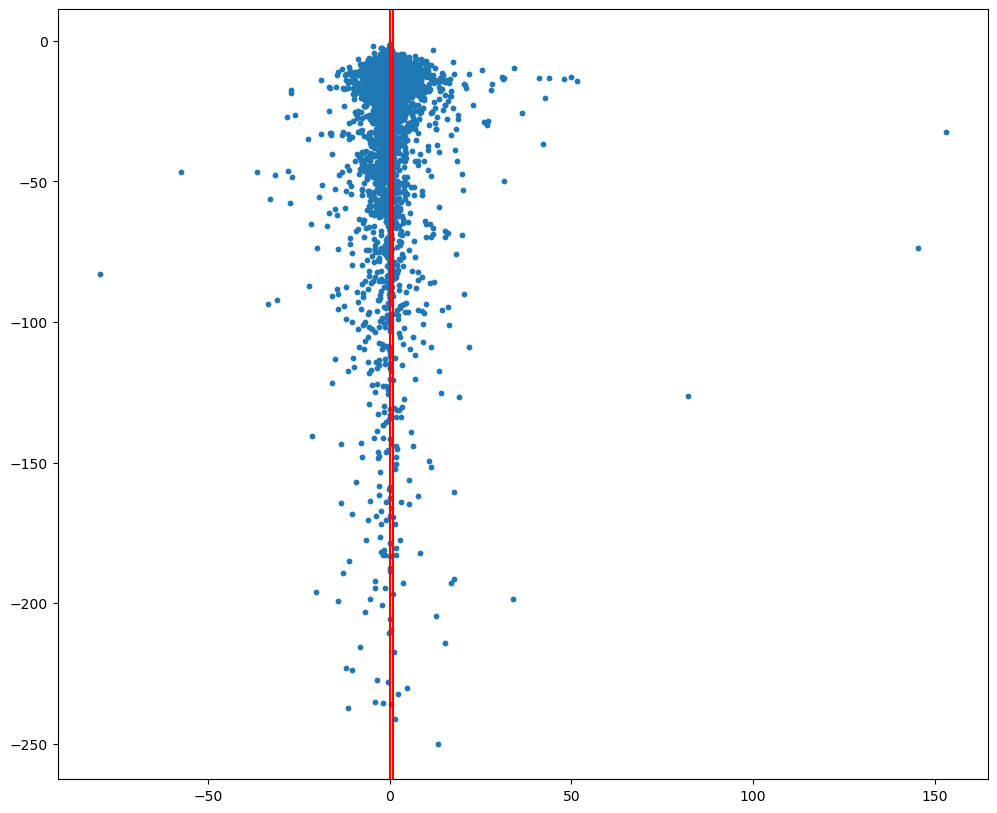

In [36]:
fig, axs = plt.subplots(1,figsize=(12, 10))
time = ds.time[0,:]
Lat,Lon,Age,Z,Wa,Ws = order_data_bytime(ds)
axs.scatter(Wa[5]/Ws[5] ,-Z[5],s=10,zorder=2)
plt.axvline(x = 1,color='r')
plt.axvline(x = 0,color='r')

In [38]:
ratio = np.divide(Wa,Ws)
rot = []
rat = []
for r in ratio:
    rot.append(len(np.where(r>1)[0])+len(np.where(r<0)[0]))
    rat.append(len(np.where(r<1)[0])-len(np.where(r<0)[0]))
np.divide(rot,rat)

/tmp/ipykernel_12190/934723125.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ratio = np.divide(Wa,Ws)


array([       nan, 0.83807267, 0.64241782, 0.67713976, 0.58261981,
       0.5733706 , 0.57097552, 0.57017878, 0.56997972, 0.57017878,
       0.57017878, 0.56997972, 0.56978071, 0.56997972, 0.56997972,
       0.56997972, 0.56997972, 0.56997972])